# **4.2 - Stop, you´re overfitting me** ❌❗
**Objetivo:** Implemente uma estratégia de Parada Antecipada (Early Stopping) no processo de treino da rede neural feita em Python puro ou no processo de treino da rede neural feita em PyTorch
***

### **Introdução** 💡

<p style="text-align:justify;">
Durante o treinamento de uma rede neural, um dos principais hiperparâmetros que precisamos considerar é o número de épocas, o qual diz respeito a quantidade de vezes que o modelo passará por um ciclo completo de treinamento - envolvendo os processos de <em>forward pass</em>, <em>backpropagation</em> e atualização dos pesos. Por um lado, um número pequeno de épocas pode provocar um <em>underfitting</em>, no qual o modelo não é capaz de capturar os padrões presentes nos dados, por outro, o treinamento por muitas épocas é capaz de provocar um sobreajuste, com a rede neural "decorando" todos os dados e apresentando desempenho insatisfatório para dados desconhecidos. Nesse sentido, evidencia-se a necessidade de encontrar uma forma de balancear esses dois fatores.
</p>

<p style="text-align:justify;">
Uma das estratégias mais adotadas para lidar com essa problemática é a utilização de parada antecipada (ou <em>Early Stopping</em>), que consiste em um método de regularização pautada no monitoramente do modelo em relação ao desempenho do conjunto de validação. Em resumo, durante o treinamento, a função <em>loss</em> (ou outra métrica de desempenho) é avaliada durante cada época. Quando a perda relativa a esses dados começa a não melhorar (ou até piorar) após um número pré-definido de épocas (denominada <em>patience</em>), o treinamento é interrompido, dado que isso indica que o modelo está se ajustando demasiadamente aos dados de treinamento. Dessa forma, é possível evitar o overfitting e garantir um treinamento adequado para a MLP treinada.
</p>

<p style="text-align:justify;">
A partir disso, esse notebook busca implementar a estratágia de parada de antecipada no treinamento de uma MLP criada a partir do módulo PyTorch. A fim de verificar se esse processo foi bem-sucedido, o dataset "California Housing" será utilizado - o qual visa a previsão do preço de casas do estado da Califórnia (EUA) por meio de features que descrevem as principais características dos imóveis. 


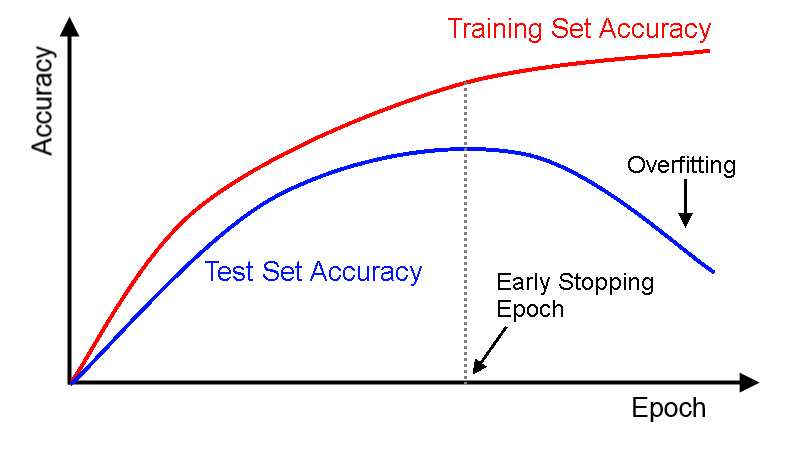

[Figura 1: Representação gráfica do conceito de parada antecipada]

### **Importação de bibliotecas** 📚

In [26]:
# Módulos PyTorch 
import torch 
import torch.nn as nn 
import torch.optim as optim

# Outras bibliotecas
from datasets import load_dataset, DatasetDict, Dataset
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error
import copy
import matplotlib.pyplot as plt
import seaborn as sns

### **Importação do Dataset** 🎲

Por meio da biblioteca "Datasets", o dataset "California Housing" será baixado.

In [2]:
df = load_dataset("gvlassis/california_housing")

In [3]:
display(df)

DatasetDict({
    train: Dataset({
        features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal'],
        num_rows: 16640
    })
    validation: Dataset({
        features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal'],
        num_rows: 2000
    })
})

Como é possível notar pela célulca acima, os dados são baixados em um formato "DatasetDict", o qual consiste em um dicionário com um conjunto de splits. Cada chave armazena como valor um objeto do tipo dataframe e, para acessar esses dados é possível utilizar o objeto "df" para acessar os indíces correspondentes. Para facilitar a manipulação desses dados, esses serão convertidos para dataframes da biblioteca Pandas.

In [4]:
df_treino = pd.DataFrame(df['train'])
df_teste = pd.DataFrame(df['test'])
df_validacao = pd.DataFrame(df['validation'])

display(df_treino)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
16635,4.9359,15.0,6.525316,1.034810,781.0,2.471519,35.30,-120.84,3.177
16636,2.5172,16.0,6.150470,1.095611,1325.0,2.076803,35.31,-120.82,2.939
16637,3.5870,20.0,6.027397,1.076712,996.0,2.728767,35.33,-120.80,3.300
16638,3.2112,20.0,6.517308,1.353846,1309.0,2.517308,35.60,-121.10,2.045


Com os conjuntos separados, é possível separar em target ("MedHouseVal", ou valor médio da casa) e features (demais colunas). Para facilitar posterior manipulação desses dados, esses serão convertidos para arrays numpy.

In [5]:
X_treino = df_treino.drop(columns=['MedHouseVal']).values
y_treino = df_treino['MedHouseVal'].values.reshape(-1,1)

X_teste = df_teste.drop(columns=['MedHouseVal']).values
y_teste = df_teste['MedHouseVal'].values.reshape(-1,1)

X_validacao = df_validacao.drop(columns=['MedHouseVal']).values
y_validacao = df_validacao['MedHouseVal'].values.reshape(-1,1)

Por fim, ainda no quesito de tratamento de dados, tantos os dados de treino quantos os dos outros dois conjuntos serão normalizados, por meio do "MinMaxScaler" da biblioteca Scikit-Learn.

$$X_c = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}$$

<p style="text-align:center">
[Fórmula 1: Normalizador por mínimo e máximo]
</p>

In [6]:
normalizador_x = MinMaxScaler()
X_treino = normalizador_x.fit_transform(X_treino)
X_teste = normalizador_x.transform(X_teste)  
X_validacao = normalizador_x.transform(X_validacao)

normalizador_y = MinMaxScaler()
y_treino = normalizador_y.fit_transform(y_treino)
y_teste = normalizador_y.transform(y_teste) 
y_validacao = normalizador_y.transform(y_validacao)     

### **Treinamento da rede** 🧠

A partir do tratamento dos dados, podemos estabelecer o pipeline para o treinamento da rede.

Em primeiro lugar, podemos estabelecer a classe MLP, que herda nn.Module e estabalece o pipeline para a criação da rede neural. A rede será composta por três camadas e a função de ativação utilizada será a Rectified Linear Unit (ReLU). [Fórmula 2]

$$
ReLU(x) = max(0, x)
$$

<p style="text-align:center;">
[Fórmula 2: Definição da ReLU]
</p>

In [7]:
class MLP(nn.Module): 
    def __init__(self, num_dados_entrada, neuronios_por_camada, num_targets):
        super().__init__() 
        
        self.camadas = nn.Sequential(
            nn.Linear(num_dados_entrada, neuronios_por_camada[0]), 
            nn.ReLU(),
            nn.Linear(neuronios_por_camada[0], neuronios_por_camada[1]),
            nn.ReLU(),
            # nn.Linear(neuronios_por_camada[1], num_targets),
            nn.Linear(neuronios_por_camada[1], neuronios_por_camada[2]),
            nn.ReLU(),
            nn.Linear(neuronios_por_camada[2], num_targets),
        )
        
    def forward(self, x): 
        x = self.camadas(x)
        return x

A partir disso, podemos inicializar a nossa MLP. Essa será composta por 8 dados de entrada (quantidade de features), 20 neurônios na primeira camada interna, 15 neurônios na segunda camada e 10 neurônios na terceira. Por se tratar de uma rede regressora, o número de neurônios na última camada será igual a 1.

In [8]:
mlp = MLP(8, [20, 15, 10], 1)

Vale ressaltar que os dados fornecidos para a rede precisam estar em formato de tensor. No contexto do Python, temos que esses são matrizes multidimensionais compostas por um único tipo de elemento - tal como os arrays do Numpy. Para essa transformação, podemos utilizar a própria biblioteca Pytorch.

In [9]:
X_treino = torch.from_numpy(X_treino).float()
X_teste = torch.from_numpy(X_teste).float()
X_validacao = torch.from_numpy(X_validacao).float()

y_treino = torch.from_numpy(y_treino).float()   
y_teste = torch.from_numpy(y_teste).float()
y_validacao = torch.from_numpy(y_validacao).float()

Como principal modificação para a implementação de Early Stopping, temos que o ciclo de treinamento precisará incluir o armazenamento dos valores de perda, os pesos que levaram a obtenção de cada valor e o valor de paciência - ou seja, a quantidade de épocas que iremos esperar para que o treino não seja interrompido após a estabilização da função de perda. Inicialmente, a melhor perda será inicializada como infinita (se tudo estiver minimamente certo, espera-se que qualquer perda seja melhor do que infinito...) e, consequentemente, nenhum peso será armazenado. Ao final, os parâmetros utilizados serão relativos a rede responsável pela menor perda. 

O otimizador utilizado será a descida do gradiente estocástico (SGD) e a taxa de aprendizado será igual a 0.01. Além disso, a função de perda utilizada será o erro quadrático médio (MSE). 

Vale ressaltar que, para melhor desempenho do critério de parada, os dados relativos a função de perda serão arredondados para 4 casas decimais, dado que, geralmente, após muitas casas as pequenas variações observadas podem ser flutuações oriundas do processo de backpropagation, as quais podem significar a presença de overfitting.

In [10]:
otimizador = optim.SGD(mlp.parameters(), lr=10**(-3))
fn_perda = nn.MSELoss()

Em relação ao valor da paciência, inicialmente, o padrão será 10 épocas.

In [11]:
menor_perda = float('inf')
pesos_menor_perda = None
paciencia = 10 

loss_treino_lista = []
loss_validacao_lista = []

mlp.train() # Modo de treinamento

for epoca in range(2000):
    
    y_pred = mlp(X_treino) # forward pass
    
    otimizador.zero_grad() # Zera os gradientes antes de calcular os novos

    loss_treino = fn_perda(y_treino, y_pred) # Cálculo da função de perda (MSE)
    loss_treino_lista.append(round(loss_treino.item(), 4)) # Adiciona a perda à lista
    loss_treino.backward() # Backpropagation
    
    otimizador.step() # Atualização dos pesos

    mlp.eval()  # Modo de validação
    with torch.no_grad():  # Desativação do cálculo do gradiente
        y_pred_val = mlp(X_validacao)
        loss_validacao = fn_perda(y_validacao, y_pred_val)
        loss_validacao_lista.append(round(loss_validacao.item(), 4))

    # Early stopping
    if loss_validacao.item() < menor_perda:
        # Se a validação for menor do que a menor perda atual, definir como nova menor perda
        menor_perda = round(loss_validacao.item(), 4)
        pesos_menor_perda = copy.deepcopy(mlp.state_dict())  # E salvar os pesos do modelo       
        paciencia = 10
    else:
        paciencia -= 1
        if paciencia == 0:
            epoca_final = epoca
            print(f"Treinamento interrompido na época {epoca_final}")
            break
# Define a rede com os parâmetros 
mlp.load_state_dict(pesos_menor_perda) # Carrega os pesos do modelo com menor perda

Treinamento interrompido na época 1649


<All keys matched successfully>

Temos que o early stopping foi ativado após 1649 épocas. A partir dos das métricas armazenadas nas listas "loss_treino_lista" e "loss_validacao_lista", é possível plotar uma curva de aprendizado.

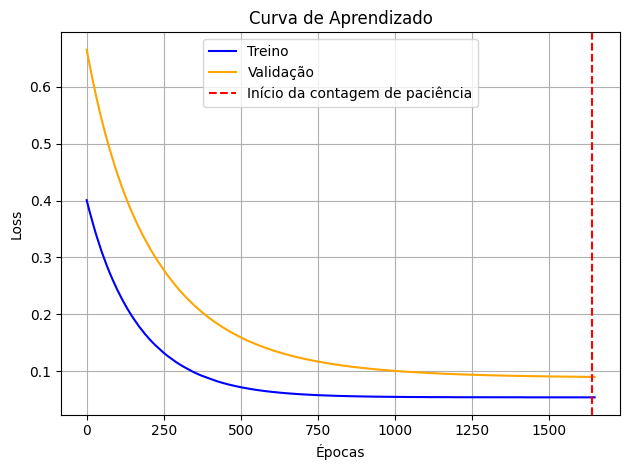

In [16]:
X_plot = list(range(0, 1650, 1))

plt.plot(X_plot, loss_treino_lista, label="Treino", color="blue")
plt.plot(X_plot, loss_validacao_lista, label="Validação", color="orange")
plt.axvline(x=1639, linestyle="--", color="r", label="Início da contagem de paciência")

plt.title("Curva de Aprendizado")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Graficamente, a linha vermelha indica o início da contagem das épocas de paciência, a qual foi iniciada em x=1639. Pelo gráfico, vemos que ambas as curvas apresentam comportamentos semelhantes, sendo que a curva referente ao conjunto de treino apresentou convergência mais rapidamente (por volta da época 750). Além disso, temos que, apesar de não ser uma confirmação, temos que a curva de aprendizado não demonstra indícios de overfitting: a perda continuou diminuindo ao longo das épocas.

Com a rede treinada, para calcular o erro em relação aos dados de teste, precisamos passar os dados de X_teste para a rede.

In [17]:
with torch.no_grad(): # não calcula os gradientes locais
    y_pred_teste = mlp(X_teste)

Finalmente, para avaliar o modelo, podemos usar a raiz quadrada do erro quadrático médio (RMSE). Porém, antes de computar a métrica, é necessário reescalonar os dados, aplicando o "inverse_transform" do normalizador. 

In [18]:
y_teste_sem_normalizacao = normalizador_y.inverse_transform(y_teste) 
y_pred_teste_sem_normalizacao = normalizador_y.inverse_transform(y_pred_teste.numpy())

In [25]:
max(y_teste_sem_normalizacao)

array([5.00001])

In [20]:
rmse = root_mean_squared_error(y_teste_sem_normalizacao, y_pred_teste_sem_normalizacao)
print(f"O RMSE da rede neural é: {rmse:.4f}")

O RMSE da rede neural é: 0.9819


Para avaliar melhor esse resultado, podemos comparar com os gráficos de distribuição dos valores do target referentes ao conjunto de teste e os valores de y preditos, por meio de um boxplot da biblioteca Seaborn.

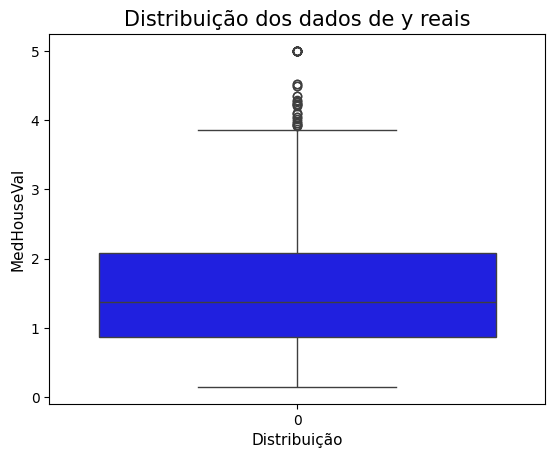

In [63]:
sns.boxplot(y_teste_sem_normalizacao, color="blue")
plt.title("Distribuição dos dados de y reais", fontdict={"fontsize": 15})
plt.xlabel("Distribuição", fontdict={"fontsize": 11})
plt.ylabel("MedHouseVal", fontdict={"fontsize": 11})
plt.style.use("default")
plt.show();

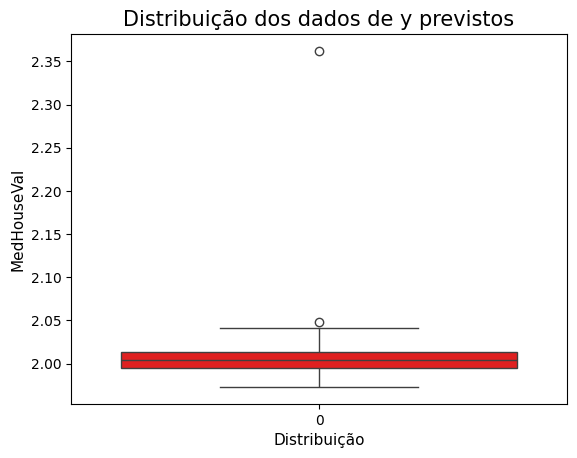

In [62]:
sns.boxplot(y_pred_teste_sem_normalizacao, color="red")
plt.title("Distribuição dos dados de y previstos", fontdict={"fontsize": 15})
plt.xlabel("Distribuição", fontdict={"fontsize": 11})
plt.ylabel("MedHouseVal", fontdict={"fontsize": 11})
plt.style.use("default")
plt.show();

Considerando que os dados de teste estão contidos em um intervalo pequeno, entre 0 e 5 (estando a maior parte entre 1 e 2) temos que o erro obtido (0.98) é alto. Além disso, é notável que a distribuição dos dados previstos é menor do que a distribuição dos dados reais. 

Logo, podemos concluir que o resultado da rede não foi totalmente satisfatório. Para a resolução dessa problemática, testes com ajustes de hiperparâmetros (número de camadas, quantidade de neurônios por camada, funções de ativação, taxa de aprendizado e otimizadores, por exemplo) poderia ser realizado.

### **Conclusão** 🧪

Ao final do notebook, foi possível implementar Early Stopping em uma Multilayer Perceptron (MLP) construída por meio do módulo Pytorch. Como principal diferença para um treinamento simples, foi preciso adicionar no ciclo de treinamento um condicional utilizado para verificar se a função de perda referente ao conjunto de validação da época atual é menor do que o da época anterior. Caso não seja, a variável paciência - usada para definir a quantidade de épocas que a função de perda pode continuar estável (ou aumentar) antes que o treinamento seja interrompido - é decrescida em uma unidade. Se essa contagem chegar a 0 antes da quantidade de épocas acabar, o ciclo de treinamento é interrompido.

Com a aplicação dessa técnica, foi possível entender de forma mais clara a importância do Early Stopping no treinamento de redes neurais, especialmente em relação à busca por modelos que evitem o sobreajuste (overfitting) e o subajuste (underfitting). Embora esse método introduza um novo hiperparâmetro — a paciência — o treinamento da rede torna-se mais eficiente, pois o número de épocas passa a ter um impacto menor no risco de overfitting. Se a paciência for bem escolhida, o treinamento será interrompido antes que o modelo se ajuste excessivamente aos dados de treino. Além disso, essa experiência proporcionou uma compreensão mais prática da utilização da curva de aprendizado, conforme abordado no notebook "Monstrinho 3.6 - Vivendo e (nem sempre) aprendendo".

### **Referências** 🗃️

[1] DSA, Equipe. Capítulo 28 - Usando Early Stopping Para Definir o Número de Épocas de Treinamento. Deep Learning Book. Disponível em: <https://www.deeplearningbook.com.br/usando-early-stopping-para-definir-o-numero-de-epocas-de-treinamento/>. Acesso em: 12 abr. 2025.

[2] torch.Tensor — PyTorch 2.6 documentation. Disponível em: <https://pytorch.org/docs/stable/tensors.html>. Acesso em: 15 abr. 2025.

[3] BHATTBHATT, Vrunda. A Step-by-Step Guide to Early Stopping in TensorFlow and PyTorch. Disponível em: <https://medium.com/@vrunda.bhattbhatt/a-step-by-step-guide-to-early-stopping-in-tensorflow-and-pytorch-59c1e3d0e376>. Acesso em: 12 abr. 2025.

[4] YADAV, Amit. A Practical Guide to Implementing Early Stopping in PyTorch for Model Training. Disponível em: <https://medium.com/biased-algorithms/a-practical-guide-to-implementing-early-stopping-in-pytorch-for-model-training-99a7cbd46e9d>. Acesso em: 12 abr. 2025.